# <h1 style="text-align: center;">Optimal Control of TCLab using a Gaussian process regression embedded in Pyomo - notebook v5b</h1>

<p style="text-align: center;">Alex Dowling<sup>a</sup>, Jacob P. Krell<sup>b</sup>, David S. Mebane<sup>b</sup>

<p style="text-align: center;"><sup>a</sup>Department of Chemical and Biomolecular Engineering, University of Notre Dame, Notre Dame, IN 46556, USA <br>
<sup>b</sup>Department of Mechanical and Aerospace Engineering, West Virginia University, Morgantown, WV, 26506-6106, USA</p>

## Method

- rolling average
- finite-diff.'s gradient
- GP $\propto$ deriv. of control signal (using piecewise values corresponding to analytic)
- fixed-step integration
- apply to step test

## Setup

In [2]:
import os
dir = os.path.abspath('')  # directory of notebook
import pandas as pd
import numpy as np
from FoKL import FoKLRoutines
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

Load and parse data:

In [3]:
data = pd.read_csv(os.path.join(dir, "tclab_sine_test.csv"))

tvec = data["Time"].values
Q1 = data["Q1"].values
TS1 = data["T1"].values

Define heater power control signal:

In [4]:
Q1f = interp1d(tvec, Q1, kind='previous')  # piecewise Q1
dQ1f_analytic = lambda t: 1500 * np.cos(30 * np.pi * t / tvec[-1]) * np.pi / tvec[-1]  # derivative of analytic Q1
dQ1f = interp1d(tvec, dQ1f_analytic(tvec), kind='previous')  # piecewise derivative of analytic Q1

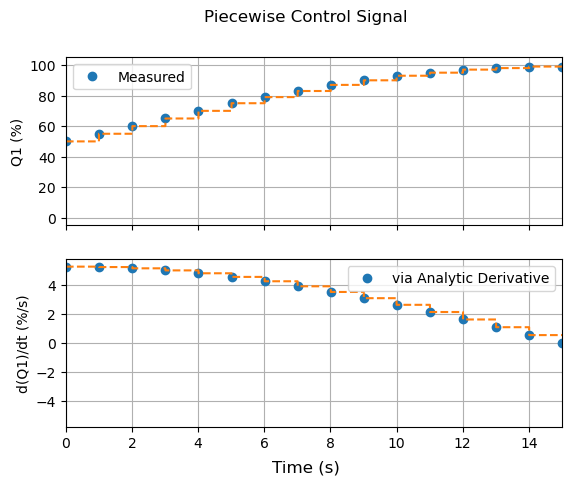

In [5]:
tvec_ub = tvec[1::] - 1e-3  # upper bounds for piecewise plots
tvec_piecewise = [tvec[0]]
for i in range(len(tvec_ub)):
    tvec_piecewise += [tvec_ub[i], tvec[i + 1]]
tvec_piecewise = np.array(tvec_piecewise)

fig, axs = plt.subplots(2, 1, sharex=True)
fig.suptitle("Piecewise Control Signal")
fig.supxlabel("Time (s)")

axs[0].plot(tvec, Q1, 'o')
axs[0].plot(tvec_piecewise, Q1f(tvec_piecewise), '--')
axs[0].set_ylabel("Q1 (%)")
axs[0].set_xlim([0, tvec[-1] / 15 / 4])
axs[0].legend(["Measured"])
axs[0].grid()

axs[1].plot(tvec, dQ1f_analytic(tvec), 'o')
axs[1].plot(tvec_piecewise, dQ1f(tvec_piecewise), '--')
axs[1].set_ylabel("d(Q1)/dt (%/s)")
axs[1].set_xlim([0, tvec[-1] / 15 / 4])
axs[1].legend(["via Analytic Derivative"])
axs[1].grid()

## Benchmark

Predicting temperatures via the two-state ODE,

In [6]:
alpha = 0.00016      # watts / (units P1 * percent U1)
P1 = 200             # P1 units
T_amb = TS1[0]       # ambient temperature
IC = [T_amb, T_amb]  # initial condition of states [TH1, TS1]
CpH =  7.006         # J/degC
CpS = 0.01           # J/degC
Ua =  0.051          # W/degC
Ub =  0.001          # W/degC

In [7]:
def dy_benchmark(t, y):
    """Benchmark ODE, for TS1."""
    TH1, TS1 = y
    dTH1 = (Ua * (T_amb - TH1) + Ub * (TS1 - TH1) + alpha * P1 * Q1f(t)) / CpH
    dTS1 = Ub * (TH1 - TS1) / CpS
    return [dTH1, dTS1]

soln_benchmark = solve_ivp(dy_benchmark, [tvec[0], tvec[-1]], IC, t_eval=tvec)

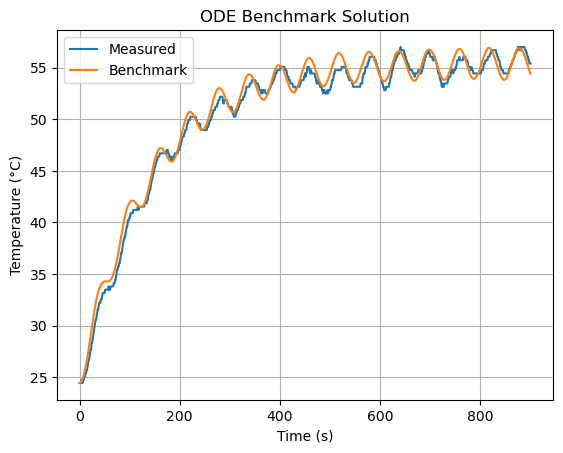

In [8]:
TS1_benchmark = soln_benchmark.y[1]

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1)
plt.plot(tvec, TS1_benchmark)
plt.grid()
plt.title('ODE Benchmark Solution')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
_ = plt.legend(['Measured', 'Benchmark'])

## Derivative of Smoothed Data

Since raw measurements are noisy, a smoothing functions is applied before calculating the time derivative.

### Smoothing

Using a rolling average as the smoothing function,

In [9]:
window = 9  # odd number, mean at center +/- floor(window/2))

In [10]:
def smooth(TS1, window):
    """Apply centered average of size window."""
    TS1_smooth = np.zeros_like(TS1)
    w2 = int(np.floor(window / 2))
    w2p1 = w2 + 1

    # bleed in:
    for i in range(w2):
        TS1_smooth[i] = np.mean(TS1[:(i + w2p1)])

    # center:
    for i in range(w2, TS1_smooth.size - w2):
        TS1_smooth[i] = np.mean(TS1[(i - w2):(i + w2p1)])

    # bleed out:
    for i in range(-w2, 0):
        TS1_smooth[i] = np.mean(TS1[(i - w2)::])

    return TS1_smooth

TS1_smooth = smooth(TS1, window)

### Derivative

In [11]:
def gradient_h4(x, h):
    """h is step size. Order of error is h^4."""
    dx = np.zeros_like(x)

    # bleed in:
    h2 = 2 * h
    dx[0] = (x[1] - x[0]) / h
    dx[1] = (x[2] - x[0]) / h2

    # center difference:
    h12 = 12 * h
    for i in range(2, x.shape[0] - 2):
        dx[i] = (x[i - 2] - 8 * x[i - 1] + 8 * x[i + 1] - x[i + 2]) / h12
    
    # bleed out:
    dx[-2] = (x[-1] - x[-3]) / h2
    dx[-1] = (x[-1] - x[-2]) / h

    return dx

dTS1 = gradient_h4(TS1_smooth, tvec[1] - tvec[0])
dTS1f = interp1d(tvec, dTS1, kind='previous')  # piecewise, grab previous value

Plotting training data:

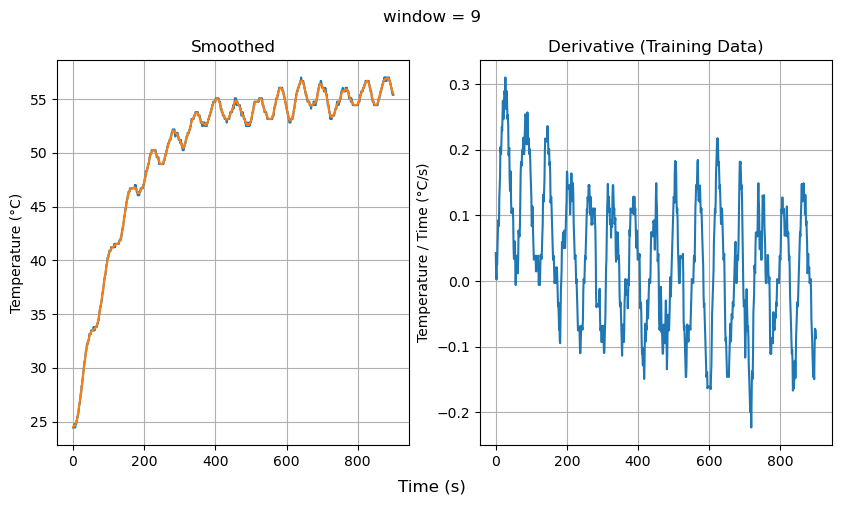

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(f"window = {window}")
fig.supxlabel("Time (s)")

axs[0].plot(TS1)
axs[0].plot(TS1_smooth)
axs[0].set_title("Smoothed")
axs[0].set_ylabel("Temperature (°C)")
axs[0].grid()

axs[1].plot(dTS1)
axs[1].set_title("Derivative (Training Data)")
axs[1].set_ylabel("Temperature / Time (°C/s)")
axs[1].grid()

Validation of training data:

In [13]:
def dy_training(t, y):
    """ODE to integrate GP's training data'."""
    return [dTS1f(t)]

soln_training = solve_ivp(dy_training, [tvec[0], tvec[-1]], [TS1_smooth[0]], t_eval=tvec, first_step=1, min_step=1, max_step=1)

/home/jacobpatrick/.local/lib/python3.12/site-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: The following arguments have no effect for a chosen solver: `min_step`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


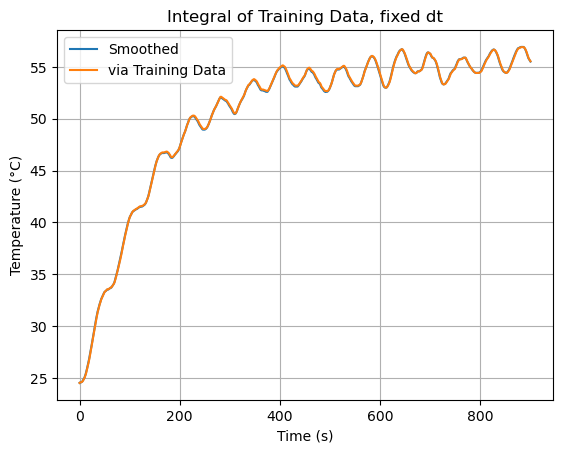

In [14]:
TS1_training = soln_training.y[0]

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1_smooth)
plt.plot(tvec, TS1_training)
plt.grid()
plt.title('Integral of Training Data, fixed dt')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
_ = plt.legend(['Smoothed', 'via Training Data'])

## GP Model of Derivative

In [15]:
GP_dT = FoKLRoutines.FoKL(kernel=1, UserWarnings=False, aic=True)
_ = GP_dT.fit([TS1_smooth, dQ1f(tvec)], dTS1, clean=True)

[1, -4743.770751535981]
[2, -4742.162753192983]
[2, -4788.446617303]
[3, -4799.100762652352]
[3, -4801.96181480126]
[4, -4801.96181480126]
[4, -4801.96181480126]
[4, -4804.41226569077]
[5, -4809.972818670285]
[5, -4811.113075237976]
[5, -4828.874515628349]
[6, -4828.874515628349]
[6, -4833.347561662446]
[6, -4833.347561662446]
[6, -4833.815082013626]
[7, -4844.664928076782]
[7, -4847.25533235577]
[7, -4847.25533235577]
[7, -4851.34746207613]
[8, -4851.34746207613]
[8, -4851.34746207613]
[8, -4861.044092740405]
[8, -4861.044092740405]
[8, -4861.044092740405]
[9, -4861.044092740405]


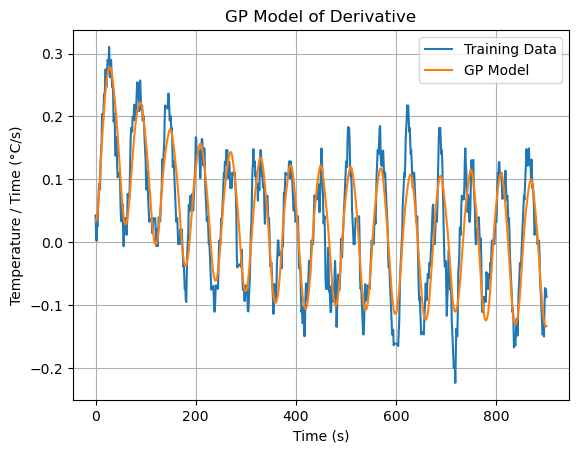

In [16]:
dTS1_GP = GP_dT.evaluate()

%matplotlib inline
plt.figure()
plt.plot(tvec, dTS1)
plt.plot(tvec, dTS1_GP)
plt.title("GP Model of Derivative")
plt.xlabel('Time (s)')
plt.ylabel('Temperature / Time (°C/s)')
plt.legend(['Training Data', 'GP Model'])
plt.grid()

Validation of GP model:

In [17]:
dt = tvec[1] - tvec[0]  # assume constant time step

def dy_GP(t, y):
    """ODE to integrate GP of derivative."""
    return [GP_dT.evaluate([y[0], dQ1f(t)], clean=True, SingleInstance=True)[0]]

soln_GP = solve_ivp(dy_GP, [tvec[0], tvec[-1]], [TS1_smooth[0]], 'LSODA', tvec, first_step=1, min_step=1, max_step=1)

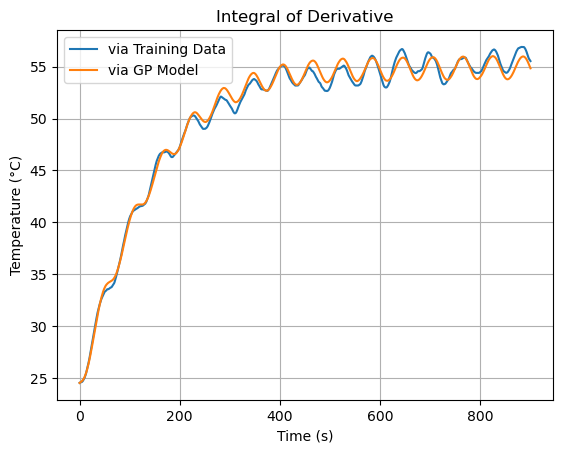

In [18]:
TS1_GP = soln_GP.y[0]

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1_training)
plt.plot(tvec, TS1_GP)
plt.title('Integral of Derivative')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['via Training Data', 'via GP Model'])
plt.grid()

## Benchmark Comparison

In [19]:
def _rmse(targets, predictions):
    return np.sqrt(np.mean((predictions - targets) ** 2))

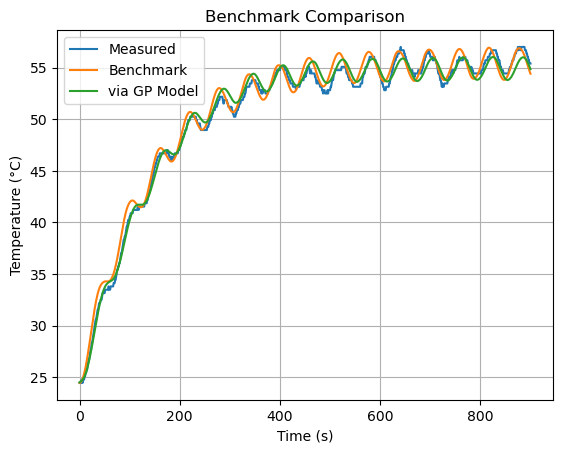

| Method       | RMSE |
|--------------|------|
| Benchmark    | 0.81 |
| via GP Model | 0.62 |


In [20]:
%matplotlib inline
plt.figure()
plt.plot(tvec, TS1)
plt.plot(tvec, TS1_benchmark)
plt.plot(tvec, TS1_GP)
plt.title('Benchmark Comparison')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['Measured', 'Benchmark', 'via GP Model'])
plt.grid()
plt.show()

RMSE_benchmark = _rmse(TS1, TS1_benchmark)
RMSE_GP = _rmse(TS1, TS1_GP)

print(f"\
| Method       | RMSE |\n\
|--------------|------|\n\
| Benchmark    | {"{0:0.2f}".format(round(RMSE_benchmark, 2))} |\n\
| via GP Model | {"{0:0.2f}".format(round(RMSE_GP, 2))} |")

## Application of Validated Dynamics $\dot{T} = f(T, \dot{Q})$ to Step Test

### Setup

In [21]:
data_test = pd.read_csv(os.path.join(dir, "tclab_step_test.csv"))

tvec_test = data_test["Time"].values
TS1_test = data_test["T1"].values

### Benchmark

In [39]:
T_amb_test = TS1_test[0]  # ambient temperature
IC_test = [T_amb_test]  # initial condition of state [TS1]
theta_test =  [0.00594762, 0.00393785]  # W/degC, from v2 'regress_results.x'

In [40]:
def dy_benchmark_test(t, y):
    """Benchmark ODE for step test (as in v2 notebook), for TS1_test. y == TS1"""
    dTS1 = theta_test[0] * (T_amb_test - y) + theta_test[1] * 50  # Q1 = 50
    return [dTS1]

soln_benchmark_test = solve_ivp(dy_benchmark_test, [tvec_test[0], tvec_test[-1]], IC_test, t_eval=tvec_test)

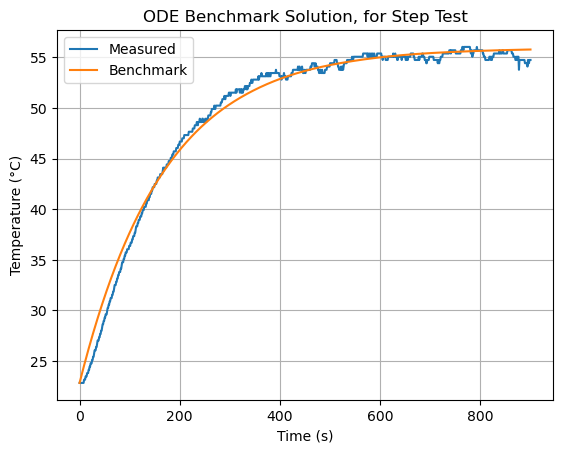

In [41]:
TS1_benchmark_test = soln_benchmark_test.y[0]

%matplotlib inline
plt.figure()
plt.plot(tvec_test, TS1_test)
plt.plot(tvec_test, TS1_benchmark_test)
plt.grid()
plt.title('ODE Benchmark Solution, for Step Test')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
_ = plt.legend(['Measured', 'Benchmark'])

### Smoothed Data

In [27]:
TS1_test_smooth = smooth(TS1_test, window)

dTS1_test = gradient_h4(TS1_test_smooth, tvec_test[1] - tvec_test[0])
dTS1f_test = interp1d(tvec_test, dTS1_test, kind='previous')  # piecewise, grab previous value

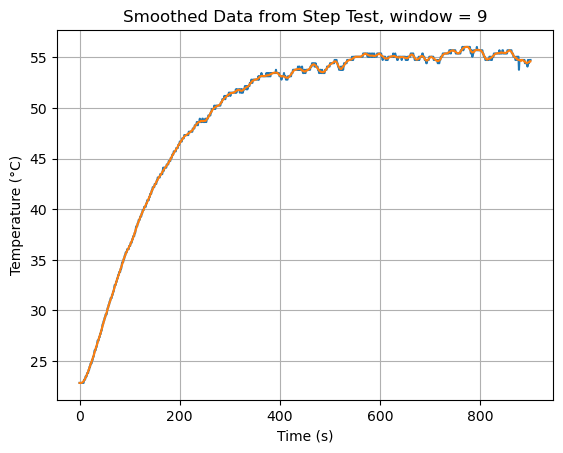

In [28]:
plt.figure()
plt.plot(tvec_test, TS1_test)
plt.plot(tvec_test, TS1_test_smooth)
plt.title(f"Smoothed Data from Step Test, window = {window}")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (°C)")
plt.grid()

### Integration of Dynamics from sine-test GP Model

In [29]:
dt_test = tvec_test[1] - tvec_test[0]  # assume constant time step

def dy_GP_test(t, y):
    """ODE to integrate GP of derivative."""
    return [GP_dT.evaluate([y[0], 0], clean=True, SingleInstance=True)[0]]  # for step, (Q1 = 50, dQ1 = 0)

soln_GP_test = solve_ivp(dy_GP_test, [tvec_test[0], tvec_test[-1]], [TS1_test_smooth[0]], 'LSODA', tvec_test, first_step=1, min_step=1, max_step=1)

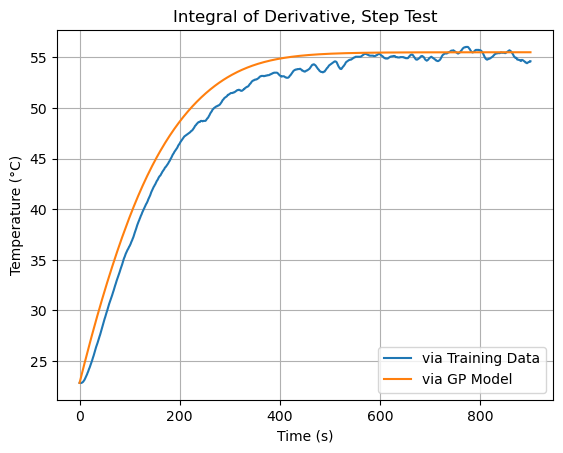

In [30]:
TS1_test_GP = soln_GP_test.y[0]

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1_test_smooth)
plt.plot(tvec, TS1_test_GP)
plt.title('Integral of Derivative, Step Test')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['via Training Data', 'via GP Model'])
plt.grid()

### Benchmark Comparison

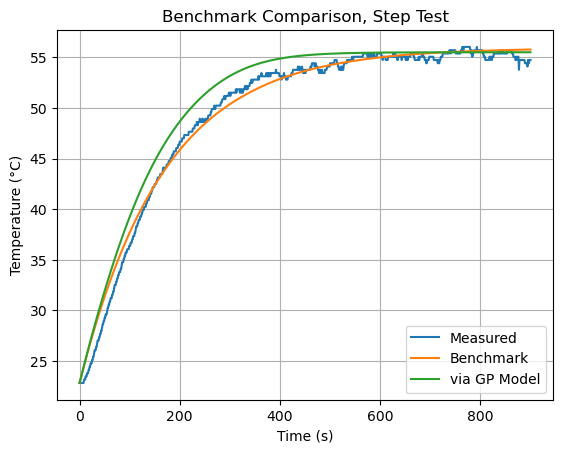

| Method       | RMSE |
|--------------|------|
| Benchmark    | 0.84 |
| via GP Model | 1.63 |


In [42]:
%matplotlib inline
plt.figure()
plt.plot(tvec_test, TS1_test)
plt.plot(tvec_test, TS1_benchmark_test)
plt.plot(tvec_test, TS1_test_GP)
plt.title('Benchmark Comparison, Step Test')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['Measured', 'Benchmark', 'via GP Model'])
plt.grid()
plt.show()

RMSE_benchmark_test = _rmse(TS1_test, TS1_benchmark_test)
RMSE_GP_test = _rmse(TS1_test, TS1_test_GP)

print(f"\
| Method       | RMSE |\n\
|--------------|------|\n\
| Benchmark    | {"{0:0.2f}".format(round(RMSE_benchmark_test, 2))} |\n\
| via GP Model | {"{0:0.2f}".format(round(RMSE_GP_test, 2))} |")

# Conclusion

$\dot{T}_{S,1}=f(T_{S,1},\ \dot{Q_1})$ dynamics from the sine test do not improve predictions of the step test. The step test, with constant $Q_1$, would likely benefit from $\dot{T}_{S,1}=f(T_{S,1},\ Q_1)$; however, with sinusoidal waves and possibly any periodic control signal, $\dot{Q_1}$ is needed since the GP cannot manipulate $Q_1$ in this way. So, notebook v5d will attempt training on data from both the sine and step tests together as $\dot{T}_{S,1}=f(T_{S,1},\ Q_1,\ \dot{Q_1})$. Then, these dynamics will be applied to both tests.